In [15]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt

In [16]:
import statsmodels.api as sm

# Load the sunspots dataset
dta = sm.datasets.sunspots.load_pandas().data

# Display the first few rows of the dataset
dta.head(10)

,YEAR,SUNACTIVITY
0,1700.0,5.0
1,1701.0,11.0
2,1702.0,16.0
3,1703.0,23.0
4,1704.0,36.0
5,1705.0,58.0
6,1706.0,29.0
7,1707.0,20.0
8,1708.0,10.0
9,1709.0,8.0


In [17]:
dta.describe()

,YEAR,SUNACTIVITY
count,309.000000,309.000000
mean,1854.000000,49.752104
std,89.344838,40.452595
min,1700.000000,0.000000
25%,1777.000000,16.000000
50%,1854.000000,40.000000
75%,1931.000000,69.800000
max,2008.000000,190.200000


In [18]:
print(sm.datasets.sunspots.NOTE)

::

    Number of Observations - 309 (Annual 1700 - 2008)
    Number of Variables - 1
    Variable name definitions::

        SUNACTIVITY - Number of sunspots for each year

    The data file contains a 'YEAR' variable that is not returned by load.



In [19]:
dta

,YEAR,SUNACTIVITY
0,1700.0,5.0
1,1701.0,11.0
2,1702.0,16.0
3,1703.0,23.0
4,1704.0,36.0
...,...,...
304,2004.0,40.4
305,2005.0,29.8
306,2006.0,15.2
307,2007.0,7.5


# Preparing the Data

Next we need to do a little dataset preparation. Here, an annual date series must be date-times at the end of the year.

In [20]:
dta.index = pd.Index(sm.tsa.datetools.dates_from_range('1700', '2008'))
del dta["YEAR"]

In [21]:
dta

,SUNACTIVITY
1700-12-31,5.0
1701-12-31,11.0
1702-12-31,16.0
1703-12-31,23.0
1704-12-31,36.0
...,...
2004-12-31,40.4
2005-12-31,29.8
2006-12-31,15.2
2007-12-31,7.5


# Examine the Data

Now we take a look at the data.

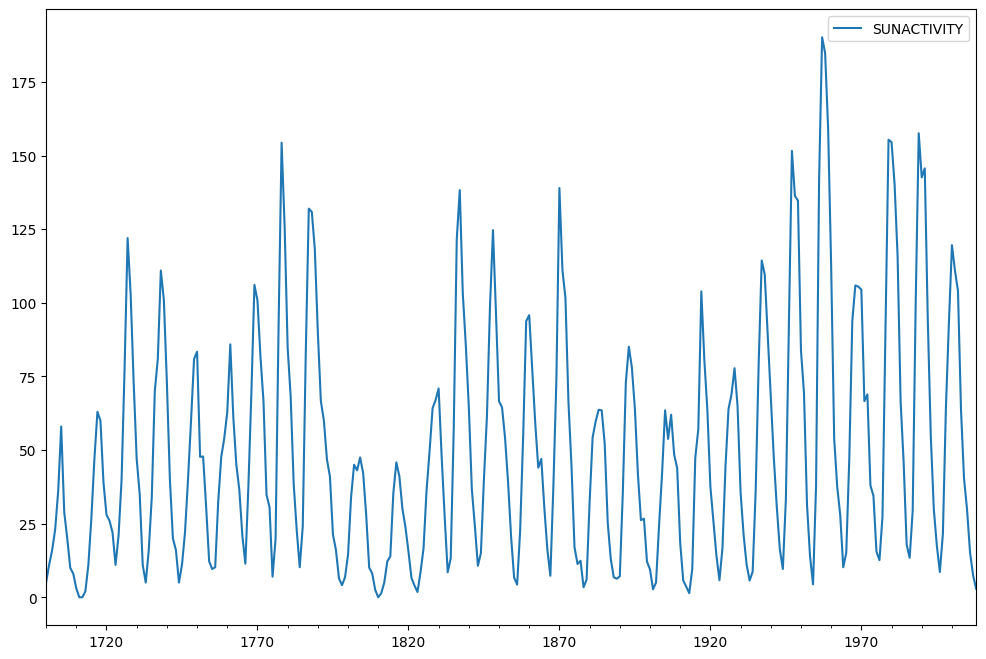

In [22]:

# show plots in the notebook
%matplotlib inline
dta.plot(figsize=(12,8));

In [23]:
sm.stats.durbin_watson(dta) ## to check autocorreation

array([0.13952893])

The value of Durbin-Watson statistic is close to 2 if the data are uncorrelated. In our example, it is 0.1395. That means that there is a strong evidence that the variable open has high autocorrelation.

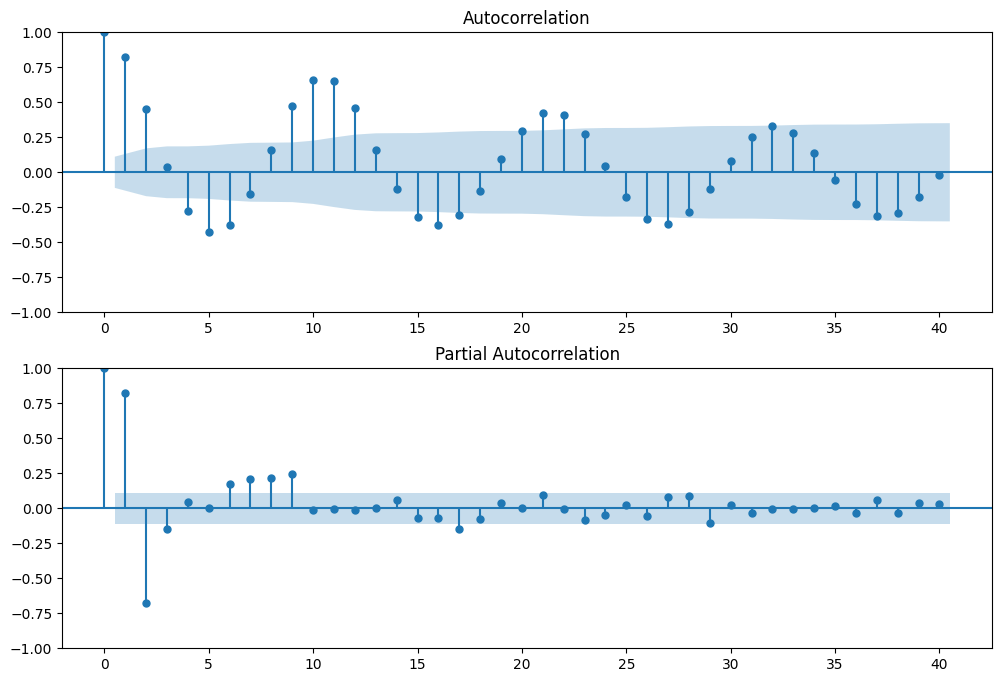

In [24]:
# show plots in the notebook
%matplotlib inline
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dta.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dta, lags=40, ax=ax2)

For mixed ARMA processes the Autocorrelation function is a mixture of exponentials and damped sine waves after (q-p) lags. The partial autocorrelation function is a mixture of exponentials and dampened sine waves after (p-q) lags.

# Modeling the Data

In [56]:
from pmdarima import auto_arima

model = auto_arima(dta, seasonal=True, m=12)
print(model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  309
Model:             SARIMAX(2, 1, 3)x(1, 0, [1], 12)   Log Likelihood               -1277.654
Date:                              Sun, 15 Oct 2023   AIC                           2571.309
Time:                                      16:28:39   BIC                           2601.150
Sample:                                  12-31-1700   HQIC                          2583.240
                                       - 12-31-2008                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6300      0.026     62.335      0.000       1.579       1.681
ar.L2         -0.94

We now calculate the Akaike Information Criterion (AIC), Schwarz Bayesian Information Criterion (BIC), and Hannan-Quinn Information Criterion (HQIC). Our goalis to choose a model that minimizes (AIC, BIC, HQIC).

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Generate or load your time series data
# For example, let's assume you have a pandas DataFrame called 'data' with a datetime index

# Define the order and seasonal_order parameters
order = (2, 1, 3)  # p: AR order, d: differencing, q: MA order
seasonal_order = (1, 0, 1, 12)  # P: seasonal AR order, D: seasonal differencing, Q: seasonal MA order, s: seasonal period

# Fit the SARIMA model
model = SARIMAX(dta, order=order, seasonal_order=seasonal_order)
results = model.fit()

# Forecast future values
forecast_steps = 12  # Adjust this based on how many steps ahead you want to forecast
forecast = results.get_forecast(steps=forecast_steps)

# Get forecasted values and confidence intervals
forecasted_values = forecast.predicted_mean
conf_int = forecast.conf_int()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency A-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency A-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


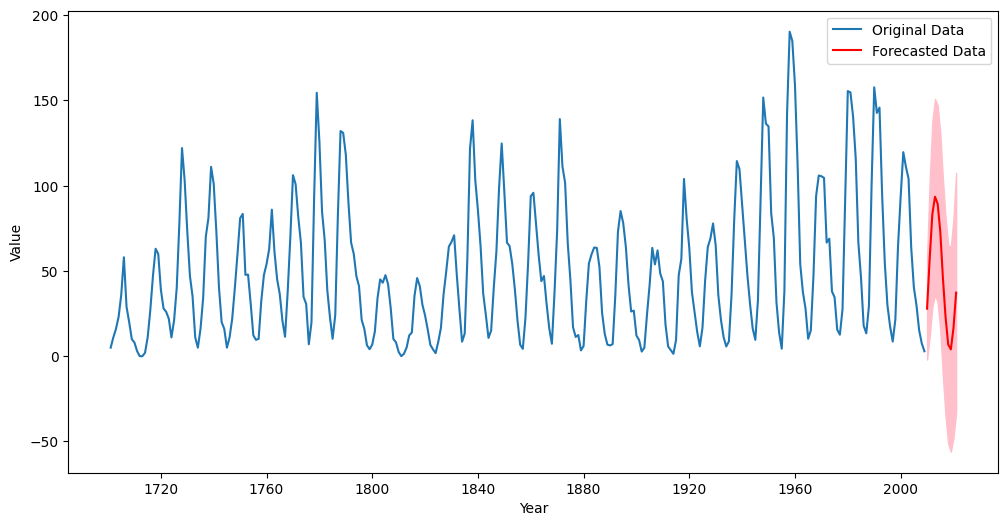

In [41]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(dta.index, dta, label='Original Data')
plt.plot(forecasted_values.index, forecasted_values, color='red', label='Forecasted Data')
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink')
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend()
plt.show()